<a href="https://colab.research.google.com/github/neuralresearch/CS39-6/blob/henry/HenryTaGSim_GraphEmbedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Type-Aware Graph Embedding

### Loading New Dataset

In [35]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
import pandas as pd
import copy
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#get the train data from the drive
id = '1s7ng3JypVvjtoUF8eUFPGroCTNtkxzIE'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('updated_train.zip')
#get the test data from the drive
id = '11FK00L91jajUW15hzjsskNkN0DRsS_yN'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('updated_test.zip')
!ls

sample_data  updated_test  updated_test.zip  updated_train  updated_train.zip


In [36]:
#if train and test exist do not run this part
#removing the dialog
%%capture
#unzip the file
!unzip updated_train.zip
!unzip updated_test.zip

### Data visualization

First graph: 265.gexf


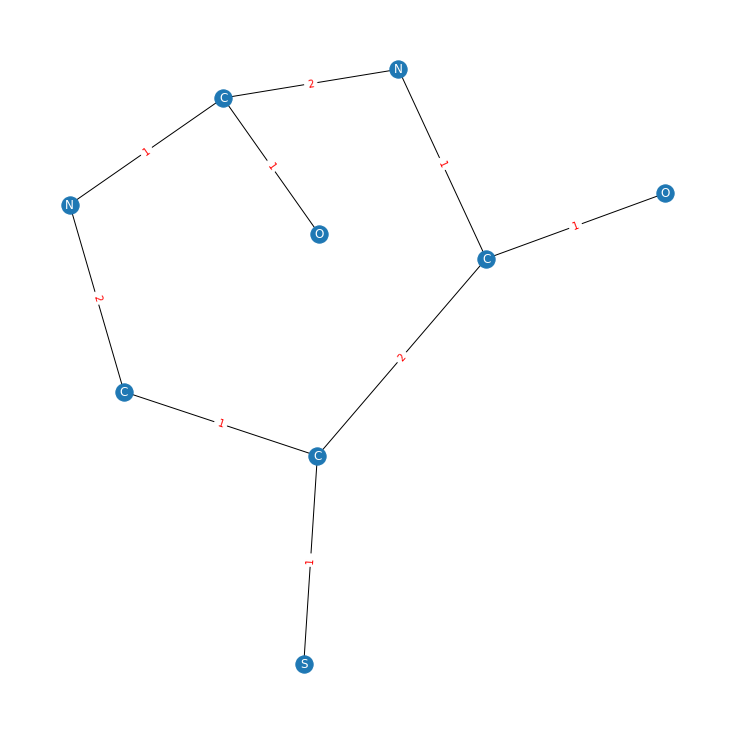

Second graph: 42322_265.gexf


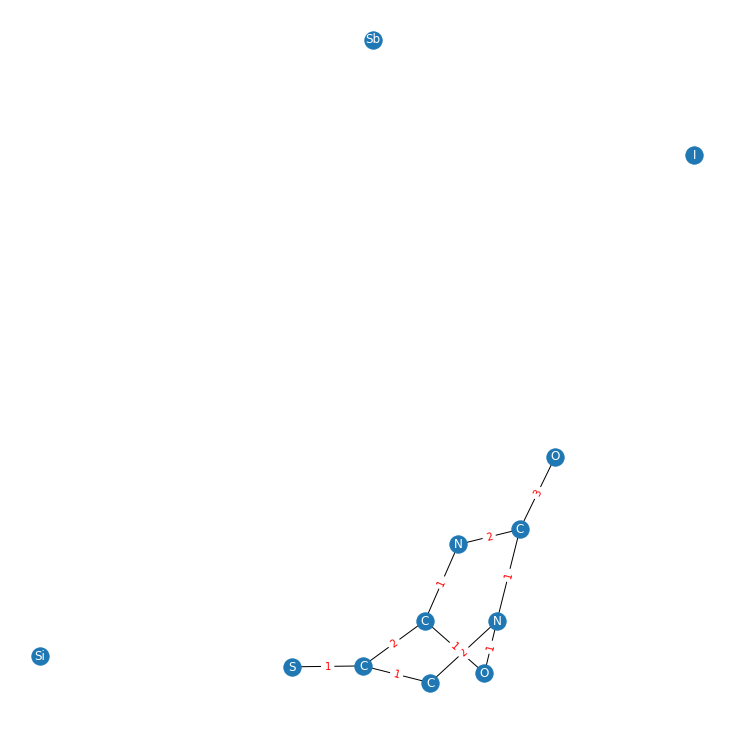

Their GEV: 42322


In [37]:
# pick a pair graph
import os
import random
import matplotlib.pyplot as plt
import networkx as nx

dirName = 'updated_train/'
filenames = os.listdir(dirName)

#pick random pair
pair_1 = random.choice(filenames)
while '_' in pair_1:
  pair_1 = random.choice(filenames)
for filename in filenames:
    if filename.endswith("_"+pair_1):
      pair_2 = filename
      gev = pair_2.split('_', 1)[0]
#read pair 1
print("First graph: "+pair_1)
graph1 = nx.read_gexf('updated_train/'+pair_1,version='1.2draft')

node_info = nx.get_node_attributes(graph1, 'type')
edge_info = dict([((n1, n2), d['valence']) for n1, n2, d in graph1.edges(data=True)])

#graph display
pos = nx.spring_layout(graph1, scale=1.5)  
plt.figure(1,figsize=(10,10)) 
nx.draw(graph1, pos, labels=node_info, font_color="white")
nx.draw_networkx_edge_labels(graph1, pos, edge_labels=edge_info, font_color="red")
plt.show()
#read pair 2
print("Second graph: "+pair_2)
graph2 = nx.read_gexf('updated_train/'+pair_2,version='1.2draft')

node_info = nx.get_node_attributes(graph2, 'type')
edge_info = dict([((n1, n2), d['valence']) for n1, n2, d in graph2.edges(data=True)])

#graph display
pos = nx.spring_layout(graph2, scale=1.5)  
plt.figure(1,figsize=(10,10)) 
nx.draw(graph2, pos, labels=node_info, font_color="white")
nx.draw_networkx_edge_labels(graph2, pos, edge_labels=edge_info, font_color="red")
plt.show()
print("Their GEV: "+gev)

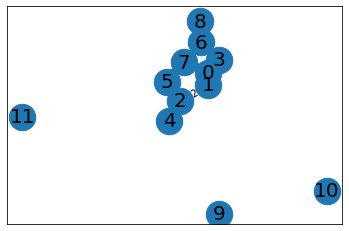

In [38]:

def draw_graph_id(G):
  pos=nx.spring_layout(G ,seed=42,scale=2)
  edgelist=G.edges
  edge_labels = nx.get_edge_attributes(G, "valence")

  nx.draw_networkx_nodes(G, pos, node_size=700)
  nx.draw_networkx_edges(G, pos, edgelist=edgelist, width=6)
  nx.draw_networkx_labels(G, pos,  font_size=20, font_family="sans-serif")
  nx.draw_networkx_edge_labels(G, pos, edge_labels)
draw_graph_id(graph2)

In [113]:
operationDict={'1':'NR','2':'NID','3':'ER','4':'EID'}

def ELM(graph,distance,labelList,maxEdgeListLen):

  labelDfList={}
  labelDictZero={} 
  for label in labelList: 
    labelDfList[label]=[]
    labelDictZero[label]=0

  fakeLabelNo=0
  while len(labelDfList)<maxEdgeListLen:
    if not str(fakeLabelNo)+'_fakeLabel' in labelDfList:
      labelDfList[str(fakeLabelNo)+'_fakeLabel']=[]
      labelDictZero[str(fakeLabelNo)+'_fakeLabel']=0
    fakeLabelNo=fakeLabelNo+1

  ELM=pd.DataFrame(labelDfList)

  nodeDistDict=dict(nx.all_pairs_shortest_path_length(graph))
  #dict(nx.all_pairs_shortest_path_length(graph1))
  #print(nodeDistDict)
  #edge_info = dict([((n1, n2), d['valence']) for n1, n2, d in graph1.edges(data=True)])
  for n1, n2, d in graph.edges(data=True):
    labelDict=copy.deepcopy(labelDictZero) 
    for n3, n4, d2 in graph.edges(data=True):
      if not n3 in nodeDistDict[n1]:
        continue
      distList=[nodeDistDict[n1][n3],    nodeDistDict[n1][n4],    nodeDistDict[n2][n3],    nodeDistDict[n2][n4]]
      nodeDist=max(distList)
      nodeDistMin=min(distList)
      if distance ==0 :
        if d['id']==d2['id']:
          labelDict[d2['valence']]=labelDict[d2['valence']]+1
      elif  distance ==1 :
        if distance==(nodeDist-1) and nodeDistMin==0:
          labelDict[d2['valence']]=labelDict[d2['valence']]+1
        elif distance==(nodeDist) and d['id']!=d2['id'] : #triangle        
          labelDict[d2['valence']]=labelDict[d2['valence']]+1
      elif distance==(nodeDist-1) :     
        labelDict[d2['valence']]=labelDict[d2['valence']]+1
    ELM = ELM.append(labelDict, ignore_index=True)
  return ELM

def getEdgeLabel(graph1,graph2):
  edge_info_1 =  graph1.edges(data=True)
  edge_info_2 =  graph2.edges(data=True)
  edgeLabel=set()
  for n1, n2, d in edge_info_1:
    edgeLabel.add(d['valence'])
  for n1, n2, d in edge_info_2:
    edgeLabel.add(d['valence'])
  return list(edgeLabel) 


def NLM(graph,distance,labelList,maxNodeListLen):

  all_pair_distance=dict(nx.all_pairs_shortest_path_length(graph))
  node_info = nx.get_node_attributes(graph, 'type')

  labelDfList={}
  labelDictZero={}
  for label in labelList:
    labelDfList[label]=[]
    labelDictZero[label]=0
  
  fakeLabelNo=0
  while len(labelDfList)<maxNodeListLen:
    if not str(fakeLabelNo)+'_fakeLabel' in labelDfList:
      labelDfList[str(fakeLabelNo)+'_fakeLabel']=[]
      labelDictZero[str(fakeLabelNo)+'_fakeLabel']=0
    fakeLabelNo=fakeLabelNo+1



  NLM=pd.DataFrame(labelDfList)
  for node in all_pair_distance:
    labelDict=copy.deepcopy(labelDictZero) 
    for other_node in all_pair_distance[node]:
      if all_pair_distance[node][other_node]==distance:
        labelDict[node_info[other_node]]=labelDict[node_info[other_node]]+1
    NLM = NLM.append(labelDict, ignore_index=True)
  return NLM
def getNodeLabel(graph1,graph2):
  node_info_1 = nx.get_node_attributes(graph1, 'type')
  node_info_2 = nx.get_node_attributes(graph2, 'type')
  nodeLabel=set()
  for node in node_info_1:
    nodeLabel.add(node_info_1[node])
  for node in node_info_2:
    nodeLabel.add(node_info_2[node])
  return list(nodeLabel)
def Embeding(graph1,graph2,nodeListLen,edgeListLen):
  NodeLabelList=getNodeLabel(graph1,graph2)
  EdgeLabelList=getEdgeLabel(graph1,graph2)


  graph1_NLM0=NLM(graph1,0,NodeLabelList,nodeListLen)
  graph1_NLM1=NLM(graph1,1,NodeLabelList,nodeListLen)
  graph1_NLM2=NLM(graph1,2,NodeLabelList,nodeListLen)
  graph1_NLM01=graph1_NLM0.merge(graph1_NLM1, left_index=True, right_index=True, how = 'right' )
  graph1_NLM01_pooling=graph1_NLM01.sum()
  graph1_NLM12=graph1_NLM1.merge(graph1_NLM2, left_index=True, right_index=True, how = 'right' )
  graph1_NLM12_pooling=graph1_NLM12.sum()

  graph1_ELM0=ELM(graph1,0,EdgeLabelList,edgeListLen)
  graph1_ELM1=ELM(graph1,1,EdgeLabelList,edgeListLen)
  graph1_ELM01=graph1_ELM0.merge(graph1_ELM1, left_index=True, right_index=True, how = 'right' )
  graph1_ELM01_pooling=graph1_ELM01.sum()


  graph2_NLM0=NLM(graph2,0,NodeLabelList,nodeListLen)
  graph2_NLM1=NLM(graph2,1,NodeLabelList,nodeListLen)
  graph2_NLM2=NLM(graph2,2,NodeLabelList,nodeListLen)
  graph2_NLM01=graph2_NLM0.merge(graph2_NLM1, left_index=True, right_index=True, how = 'right' )
  graph2_NLM01_pooling=graph2_NLM01.sum()
  graph2_NLM12=graph2_NLM1.merge(graph2_NLM2, left_index=True, right_index=True, how = 'right' )
  graph2_NLM12_pooling=graph2_NLM12.sum()

  graph2_ELM0=ELM(graph2,0,EdgeLabelList,edgeListLen)
  graph2_ELM1=ELM(graph2,1,EdgeLabelList,edgeListLen)
  graph2_ELM01=graph2_ELM0.merge(graph2_ELM1, left_index=True, right_index=True, how = 'right' )
  graph2_ELM01_pooling=graph2_ELM01.sum()
  #[NLM01,NLM12,ELM01]
  graph1_embedding={'NLM01':torch.FloatTensor(graph1_NLM01_pooling.tolist()), 'NLM12':torch.FloatTensor(graph1_NLM12_pooling.tolist()), 'ELM01':torch.FloatTensor(graph1_ELM01_pooling.tolist())}
  graph2_embedding={'NLM01':torch.FloatTensor(graph2_NLM01_pooling.tolist()), 'NLM12':torch.FloatTensor(graph2_NLM12_pooling.tolist()), 'ELM01':torch.FloatTensor(graph2_ELM01_pooling.tolist())}

  return {'graph1':graph1_embedding, 'graph2':graph2_embedding}

#NLM(graph2,1,NodeLabelList)
def generate_data(graph1,graph2,gev,nodeListLen,edgeListLen):
  result=Embeding(graph1,graph2,nodeListLen,edgeListLen)
  result['gev']=({operationDict[key]:gev.count(key)  for key in ['1', '2', '3', '4']})
  return result
data=generate_data(graph1,graph2,gev,9,6)

In [161]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

In [46]:
v1=torch.FloatTensor(data[0][0])

In [47]:
v2=torch.FloatTensor(data[1][0])


In [63]:
from networkx.algorithms.flow.mincost import max_flow_min_cost
# pick a pair graph
import os
import random
import matplotlib.pyplot as plt
import networkx as nx

maxNodeLabelList=[]
maxEdgeLabelList=[]

dirNameTrain = 'updated_train/'
dirNameTest = 'updated_test/'
trainSet=[]
testSet=[]

filenames = os.listdir(dirNameTrain)

for pair_1 in filenames:
  if '_' in pair_1:
    continue
  pair_2=''
  for filename2 in filenames:
    if filename2.endswith("_"+pair_1):
      pair_2 = filename2
      gev = pair_2.split('_', 1)[0]
  graph1 = nx.read_gexf(dirNameTrain+pair_1,version='1.2draft')
  graph2 = nx.read_gexf(dirNameTrain+pair_2,version='1.2draft')
  NodeLabelList=getNodeLabel(graph1,graph2)
  EdgeLabelList=getEdgeLabel(graph1,graph2)
  if len(NodeLabelList)>len(maxNodeLabelList):
    maxNodeLabelList=NodeLabelList
  if len(EdgeLabelList)>len(maxEdgeLabelList):
    maxEdgeLabelList=EdgeLabelList

filenames = os.listdir(dirNameTest)
for pair_1 in filenames:
  if '_' in pair_1:
    continue
  pair_2=''
  for filename2 in filenames:
    if filename2.endswith("_"+pair_1):
      pair_2 = filename2
      gev = pair_2.split('_', 1)[0]
  graph1 = nx.read_gexf(dirNameTest+pair_1,version='1.2draft')
  graph2 = nx.read_gexf(dirNameTest+pair_2,version='1.2draft')
  NodeLabelList=getNodeLabel(graph1,graph2)
  EdgeLabelList=getEdgeLabel(graph1,graph2)
  if len(NodeLabelList)>len(maxNodeLabelList):
    maxNodeLabelList=NodeLabelList
  if len(EdgeLabelList)>len(maxEdgeLabelList):
    maxEdgeLabelList=EdgeLabelList
maxNodeListLen=len(maxNodeLabelList)
maxEdgeListLen=len(maxEdgeLabelList)

In [149]:
trainSet=[]
filenames = os.listdir(dirNameTrain)
for pair_1 in filenames:
  if '_' in pair_1:
    continue
  pair_2=''
  for filename2 in filenames:
    if filename2.endswith("_"+pair_1):
      pair_2 = filename2
      gev = pair_2.split('_', 1)[0]
  graph1 = nx.read_gexf(dirNameTrain+pair_1,version='1.2draft')
  graph2 = nx.read_gexf(dirNameTrain+pair_2,version='1.2draft')
  trainSet.append(generate_data(graph1,graph2,gev,maxNodeListLen,maxEdgeListLen))

In [160]:
testSet=[]
filenames = os.listdir(dirNameTest)
for pair_1 in filenames:
  if '_' in pair_1:
    continue
  pair_2=''
  for filename2 in filenames:
    if filename2.endswith("_"+pair_1):
      pair_2 = filename2
      gev = pair_2.split('_', 1)[0]
  graph1 = nx.read_gexf(dirNameTest+pair_1,version='1.2draft')
  graph2 = nx.read_gexf(dirNameTest+pair_2,version='1.2draft')
  testSet.append(generate_data(graph1,graph2,gev,maxNodeListLen,maxEdgeListLen))

In [87]:
NR_NTN_B=nn.Bilinear(maxNodeListLen*2, maxNodeListLen*2, 16,bias=False)
NR_NTN_L=nn.Linear(maxNodeListLen * 2*2, 16)

In [88]:
NR_NTN_W2_B=NR_NTN_L(torch.cat((data['graph1']['NLM01'],data['graph2']['NLM01']), -1))
NR_NTN_W1=NR_NTN_B(data['graph1']['NLM01'],data['graph2']['NLM01'])
F.relu(NR_NTN_W2_B+NR_NTN_W1)

tensor([ 0.0000, 73.9425,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000, 29.5217, 12.2709,  0.0000, 54.9315,  0.0000, 28.9611, 36.0224],
       grad_fn=<ReluBackward0>)

In [151]:

class TaGSim(nn.Module):

    def __init__(self,maxNodeListLen,maxEdgeListLen):
        super(TaGSim, self).__init__()
        
        NTN_outputFeature=16
        FC1_output=8
        FC2_output=4
        self.NR_NTN_B=nn.Bilinear(maxNodeListLen*2, maxNodeListLen*2, 16,bias=False)
        self.NR_NTN_L=nn.Linear(maxNodeListLen * 2*2, NTN_outputFeature)
        self.NR_FC1=torch.nn.Linear(NTN_outputFeature, FC1_output)
        self.NR_FC2=torch.nn.Linear(FC1_output, FC2_output)
        self.NR_FC3=torch.nn.Linear(FC2_output, 1)


        self.ER_NTN_B=nn.Bilinear(maxEdgeListLen*2, maxEdgeListLen*2, 16,bias=False)
        self.ER_NTN_L=nn.Linear(maxEdgeListLen * 2*2, NTN_outputFeature)
        self.ER_FC1=torch.nn.Linear(NTN_outputFeature, FC1_output)
        self.ER_FC2=torch.nn.Linear(FC1_output, FC2_output)
        self.ER_FC3=torch.nn.Linear(FC2_output, 1)



        self.EID_NTN_B=nn.Bilinear((maxEdgeListLen+maxNodeListLen)*2, (maxEdgeListLen+maxNodeListLen)*2, 16,bias=False)
        self.EID_NTN_L=nn.Linear((maxEdgeListLen+maxNodeListLen) * 2*2, NTN_outputFeature)
        self.EID_FC1=torch.nn.Linear(NTN_outputFeature, FC1_output)
        self.EID_FC2=torch.nn.Linear(FC1_output, FC2_output)
        self.EID_FC3=torch.nn.Linear(FC2_output, 1)

    def forward(self, data):
        #NTN 
        NR_vector1=data['graph1']['NLM01']
        NR_vector2=data['graph2']['NLM01']
        NR_NTN_W2_B=self.NR_NTN_L(torch.cat((NR_vector1,NR_vector2), -1))
        NR_NTN_W1=self.NR_NTN_B(NR_vector1,NR_vector2)
        NR =F.relu(NR_NTN_W2_B+NR_NTN_W1)

        NR =F.relu(self.NR_FC1(NR))
        NR =F.relu(self.NR_FC2(NR))
        NR =F.relu(self.NR_FC3(NR))
        

        ER_vector1=data['graph1']['ELM01']
        ER_vector2=data['graph2']['ELM01']
        ER_NTN_W2_B=self.ER_NTN_L(torch.cat((ER_vector1,ER_vector2), -1))
        ER_NTN_W1=self.ER_NTN_B(ER_vector1,ER_vector2)
        ER =F.relu(ER_NTN_W2_B+ER_NTN_W1)
        ER =F.relu(self.ER_FC1(ER))
        ER =F.relu(self.ER_FC2(ER))
        ER =F.relu(self.ER_FC3(ER))
        
        EID_vector1=torch.cat((data['graph1']['ELM01'],data['graph1']['NLM12']), -1) 
        EID_vector2=torch.cat((data['graph2']['ELM01'],data['graph2']['NLM12']), -1)         
        EID_NTN_W2_B=self.EID_NTN_L(torch.cat((EID_vector1,EID_vector2), -1))
        EID_NTN_W1=self.EID_NTN_B(EID_vector1,EID_vector2)
        EID =F.relu(EID_NTN_W2_B+EID_NTN_W1)
        EID =F.relu(self.EID_FC1(EID))
        EID =F.relu(self.EID_FC2(EID))
        EID =F.relu(self.EID_FC3(EID))

        result=torch.cat((NR,ER,EID), -1)  
        return result

In [172]:

model=TaGSim(maxNodeListLen,maxEdgeListLen)

learning_rate=0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
total_epoch=100

train_loss_array=[]
test_loss_array=[]
lossRecordArray=[]

start = time.time()
for epoch in range(total_epoch):
  optimizer.zero_grad()
  model.train()
  trainLosses = 0
  for data in trainSet:

    
    # forward + backward + optimize
    GEV=data['gev']
    targe_torch=torch.FloatTensor([GEV['NR'],GEV['ER'],GEV['EID']])
    outputs = model(data) 
    trainLosses += F.mse_loss(outputs, targe_torch)
  trainLosses.backward(retain_graph=True )
  optimizer.step()



  if epoch%10==9:
    testLosses = 0
    for data in testSet:

      
      # forward + backward + optimize
      GEV=data['gev']
      targe_torch=torch.FloatTensor([GEV['NR'],GEV['ER'],GEV['EID']])
      outputs = model(data) 
      testLosses += F.mse_loss(outputs, targe_torch)
    test_loss_array.append(testLosses.item()/len(testSet))
    train_loss_array.append(trainLosses.item()/len(trainSet))
    lossRecordArray.append(epoch+1)
    print('Epoch: %d, loss: %.5f ; test loss:  %.5f' %(epoch + 1, trainLosses.item()/len(trainSet),testLosses.item()/len(testSet)))


plt.figure(figsize=(10, 7))
plt.plot(lossRecordArray,train_loss_array, color='orange', label='train loss')
plt.plot(lossRecordArray,test_loss_array, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


end = time.time()
print('Time of Trainging',end - start)

Epoch: 10, loss: 4.06533 ; test loss:  4.17954
Epoch: 20, loss: 3.44132 ; test loss:  3.36955
Epoch: 30, loss: 3.24390 ; test loss:  3.12179
Epoch: 40, loss: 3.07744 ; test loss:  3.05244
Epoch: 50, loss: 2.96229 ; test loss:  2.96197
Epoch: 60, loss: 2.85366 ; test loss:  2.84070
Epoch: 70, loss: 2.73677 ; test loss:  2.74177
Epoch: 80, loss: 2.61919 ; test loss:  2.64699
Epoch: 90, loss: 2.51610 ; test loss:  2.60411
Epoch: 100, loss: 2.43389 ; test loss:  2.58524
Epoch: 110, loss: 2.37199 ; test loss:  2.57817
Epoch: 120, loss: 2.32251 ; test loss:  2.57264
Epoch: 130, loss: 2.27953 ; test loss:  2.56260
Epoch: 140, loss: 2.24121 ; test loss:  2.55178
Epoch: 150, loss: 2.20539 ; test loss:  2.54034
Epoch: 160, loss: 2.17259 ; test loss:  2.52476
Epoch: 170, loss: 2.14361 ; test loss:  2.50006
Epoch: 180, loss: 2.11749 ; test loss:  2.47607
Epoch: 190, loss: 2.09406 ; test loss:  2.45581
Epoch: 200, loss: 2.07418 ; test loss:  2.44040
Epoch: 210, loss: 2.05707 ; test loss:  2.43101
E

KeyboardInterrupt: ignored

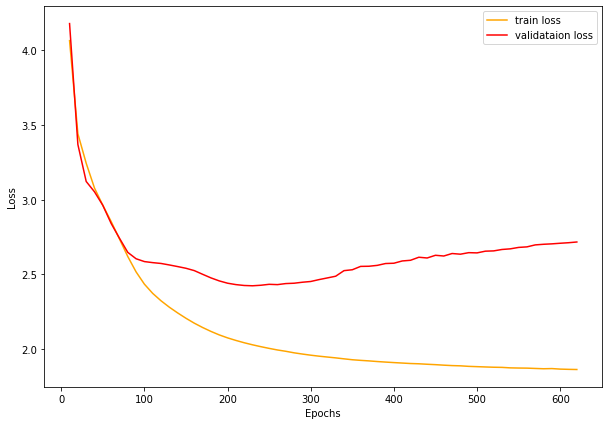

Time of Trainging 845.9894914627075


In [173]:

plt.figure(figsize=(10, 7))
plt.plot(lossRecordArray,train_loss_array, color='orange', label='train loss')
plt.plot(lossRecordArray,test_loss_array, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


end = time.time()
print('Time of Trainging',end - start)

In [170]:

GEV=data['gev']
targe_torch=torch.FloatTensor([GEV['NR'],GEV['ER'],GEV['EID']])
targe_torch

tensor([1., 2., 0.])

In [166]:
test_loss_array[8]

3.3270841326032365

In [167]:
train_loss_array[9]

3.342366027832031